In [1]:
import numpy as np
import os
import shutil
from dotenv import load_dotenv
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from collections import Counter

import torch
from torch.utils.data import TensorDataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

from tqdm.auto import tqdm

import wandb

c:\conda-envs\envs\DLankle\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if torch.cuda.is_available():
    print(f"CUDA available: {torch.cuda.is_available()}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"\nGPU {i}: {torch.cuda.get_device_name(i)}")
        props = torch.cuda.get_device_properties(i)
        print(f"  Memory: {props.total_memory / 1024**3:.2f} GB")
        print(f"  Compute Capability: {props.major}.{props.minor}")
else:
    print("CUDA not available")

CUDA available: True
Number of GPUs: 1

GPU 0: NVIDIA GeForce RTX 4060
  Memory: 8.00 GB
  Compute Capability: 8.9


In [3]:
# Prepare the data
data_folder = '../data'
image_formats = ['.jpg', '.jpeg', '.png', '.bmp']
output_folder = os.path.join(data_folder, '_preped')
os.makedirs(output_folder, exist_ok=True)

for foldername in os.listdir(data_folder):
    folder_path = os.path.join(data_folder, foldername)
    if os.path.isdir(folder_path) and foldername != '_preped':
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            if os.path.isfile(file_path):
                name, extension = os.path.splitext(filename)
                if extension in image_formats:
                    new_filename = f"{foldername}_{name}{extension}"
                    new_file_path = os.path.join(output_folder, new_filename)
                    shutil.copy2(file_path, new_file_path)

In [4]:
label_file = ''
# Create labels folder and save modified JSON
labels_folder = '../data/_labels'
os.makedirs(labels_folder, exist_ok=True)
for foldername in os.listdir(data_folder):
    folder_path = os.path.join(data_folder, foldername)
    if os.path.isdir(folder_path) and foldername != '_labels': 
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            if os.path.isfile(file_path):
                name, extension = os.path.splitext(filename)
                if extension == '.json':
                    label_file = file_path
                    break
                else:
                    label_file = 'not found'
        if label_file == 'not found':
            print(f"No label file found in folder: {foldername}")
            continue

        print(f"Label file found: {label_file}")
        with open(label_file, 'r', encoding='utf-8') as f:
            data = json.load(f)

        cnt = 0
        # Process each entry
        for entry in data:
            if 'file_upload' in entry:
                # Remove labelstudio hash prefix
                parts = entry['file_upload'].split('-', 1)  # Split only on first '-'
                if len(parts) > 1:
                    entry['file_upload'] = f"{foldername}_{parts[1]}"
                    cnt += 1

        # Get original filename and create new path
        original_filename = os.path.basename(label_file)
        new_label_path = os.path.join(labels_folder, original_filename)

        # Save the modified JSON
        with open(new_label_path, 'w', encoding='utf-8') as f:
            json.dump(data, f, indent=4, ensure_ascii=False)
        print(f"Total entries updated: {cnt}")

Label file found: ../data\B8V41Y\b8v41y.json
Total entries updated: 20
Label file found: ../data\C6037J\C6037J.json
Total entries updated: 34
Label file found: ../data\consensus\b8v41y.json
Total entries updated: 57
Label file found: ../data\D6AE9F\D6AE9F.json
Total entries updated: 22
No label file found in folder: ECSGGY
Label file found: ../data\FGWUFP\FGWUFP.json
Total entries updated: 20
Label file found: ../data\FO6K58\FO6K58_labels.json
Total entries updated: 32
No label file found in folder: GI9Y8B
Label file found: ../data\GK1XQ4\project-1-at-2025-10-15-23-46-9d203653.json
Total entries updated: 52
Label file found: ../data\H51B9J\H51B9J.json
Total entries updated: 23
Label file found: ../data\ITWQ3V\ITWQ3V.json
Total entries updated: 23
Label file found: ../data\NC1O2T\hf_labels_export.json
Total entries updated: 20
Label file found: ../data\NX9GA4\NX9GA4_ankles_labeled.json
Total entries updated: 20
Label file found: ../data\ODZF0M\project-2-at-2025-10-16-02-08-8ee4fdfa.json

In [5]:
#Match the file names with the labels
image_names = list(os.listdir(output_folder))
data_ready = []
for label_filename in os.listdir(labels_folder):
    label_path = os.path.join(labels_folder, label_filename)
    with open(label_path, 'r', encoding='utf-8') as f:
        labels = json.load(f)
    for entry in labels:
        if 'file_upload' in entry:
            if entry['file_upload'] in image_names:
                result = entry['annotations'][0].get('result')
                if len(result) > 0:
                    label = result[0].get('value').get('choices')[0]
                    data_ready.append((entry['file_upload'], label))
print(f"Total matched entries: {len(data_ready)}")

Total matched entries: 244


In [6]:
# Reaname the 3 wrong labels:
for i in range(len(data_ready)):
    imge_name, label = data_ready[i]
    if label == 'neutral': data_ready[i] = (imge_name, '2_Neutralis')
    elif label == 'pronation': data_ready[i] = (imge_name, '1_Pronacio')
    elif label == 'supination': data_ready[i] = (imge_name, '3_Szupinacio')

# Get the majority class
labels = [label for _, label in data_ready]

unique_labels, counts = np.unique(labels, return_counts=True)
majority_class = unique_labels[np.argmax(counts)]
print(f"Majority class: {majority_class}")

Majority class: 1_Pronacio


In [7]:

# Baseline: Always predict the majority class
def baseline_predict(data):
    return [majority_class] * len(data)

# Evaluate baseline accuracy
true_labels = labels
predicted_labels = baseline_predict(data_ready)
accuracy = np.mean([true == pred for true, pred in zip(true_labels, predicted_labels)])
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Baseline accuracy: {accuracy * 100:.2f}%")
print(f"Baseline precision: {precision * 100:.2f}%")
print(f"Baseline recall: {recall * 100:.2f}%")
print(f"Baseline F1-score: {f1 * 100:.2f}%")

# For detailed per-class metrics
print("\nDetailed Classification Report:")
print(classification_report(true_labels, predicted_labels))


Baseline accuracy: 43.03%
Baseline precision: 18.52%
Baseline recall: 43.03%
Baseline F1-score: 25.89%

Detailed Classification Report:
              precision    recall  f1-score   support

  1_Pronacio       0.43      1.00      0.60       105
 2_Neutralis       0.00      0.00      0.00       100
3_Szupinacio       0.00      0.00      0.00        39

    accuracy                           0.43       244
   macro avg       0.14      0.33      0.20       244
weighted avg       0.19      0.43      0.26       244



c:\conda-envs\envs\DLankle\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\conda-envs\envs\DLankle\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\conda-envs\envs\DLankle\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\conda-envs\envs\DLa

In [8]:
# Read what picture are in consensus text file
consensus_file_path =  os.path.join(data_folder, 'consensus')
consensus_file = os.path.join(consensus_file_path, 'anklealign-consensus.txt')
with open(consensus_file, 'r', encoding='utf-8') as f:
    consensus_images = f.read().splitlines()

img_names = []
# Get every image name from the consensus file
for img in consensus_images:
    parts = img.split('\\')
    if len(parts) > 1:
        img_names.append(parts[-1])

# Count occurrences of each image name
img_counts = Counter(img_names)

# Keep only images that appear exactly once
unique_consensus_image_names = [img for img, count in img_counts.items() if count == 1]

print(f"Total images in consensus: {len(img_names)}")
print(f"Unique images (appearing exactly once): {len(unique_consensus_image_names)}")
print(f"Duplicate images removed: {len(img_names) - len(unique_consensus_image_names)}")

Total images in consensus: 57
Unique images (appearing exactly once): 49
Duplicate images removed: 8


In [9]:
consensus_label_matrix = pd.DataFrame({
    'image': unique_consensus_image_names,
    '1_Pronacio': 0,
    '2_Neutralis': 0,
    '3_Szupinacio': 0
})

for consensus_label_file in os.listdir(consensus_file_path):
    extension = os.path.splitext(consensus_label_file)[1]
    consensus_label_path = os.path.join(consensus_file_path, consensus_label_file)
    if extension != '.json' or os.path.getsize(consensus_label_path) == 0:
        continue

    with open(consensus_label_path, 'r', encoding='utf-8') as f:
        labels = json.load(f)
    for entry in labels:
        if 'file_upload' in entry:
            img_name = entry['file_upload'].split('-', 1)[1]  # Remove hash prefix
            if img_name in unique_consensus_image_names:
                result = entry['annotations'][0].get('result')
                if len(result) > 0:
                    label = result[0].get('value').get('choices')[0]
                    if label == '1_Pronacio':
                        consensus_label_matrix.loc[consensus_label_matrix['image'] == img_name, '1_Pronacio'] += 1
                    elif label == '2_Neutralis':
                        consensus_label_matrix.loc[consensus_label_matrix['image'] == img_name, '2_Neutralis'] += 1
                    elif label == '3_Szupinacio':
                        consensus_label_matrix.loc[consensus_label_matrix['image'] == img_name, '3_Szupinacio'] += 1

In [10]:
unique_consensus_images = []

# Rename the images as the prepared data
for img in consensus_images:
    parts = img.split('\\')
    if len(parts) > 1 and parts[2] in unique_consensus_image_names:
        row = consensus_label_matrix.loc[consensus_label_matrix['image'] == parts[2]]
        max_col = row[['1_Pronacio', '2_Neutralis', '3_Szupinacio']].idxmax(axis=1).values[0]
        label = max_col
        unique_consensus_images.append((f"{parts[1]}_{parts[2]}", label))
print(len(unique_consensus_images))

49


In [11]:
# Match the consensus images with the prepared data
matched_consensus = []
for img, _ in unique_consensus_images:
    for data_img, _ in data_ready:
        if img == data_img:
            matched_consensus.append((data_img))

train_data = [(img, label) for img, label in data_ready if img not in matched_consensus]
test_data = unique_consensus_images


In [12]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to consistent size
    transforms.ToTensor(),           # Convert to tensor [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

x_train = []
y_train = []

for img_name, label in train_data:
    img_path = os.path.join(output_folder, img_name)
    try:
        img = Image.open(img_path).convert('RGB')
        img_tensor = transform(img)
        x_train.append(img_tensor)
        y_train.append(label)
    except Exception as e:
        print(f"Error loading {img_name}: {e}")

# Stack into tensors
x_train_tensor = torch.stack(x_train)
print(f"Training images shape: {x_train_tensor.shape}")

# Encode labels to integers
label_to_idx = {label: idx for idx, label in enumerate(np.unique(y_train))}
y_train_encoded = [label_to_idx[label] for label in y_train]
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)

print(f"Training labels shape: {y_train_tensor.shape}")
print(f"Label mapping: {label_to_idx}")

Training images shape: torch.Size([221, 3, 224, 224])
Training labels shape: torch.Size([221])
Label mapping: {np.str_('1_Pronacio'): 0, np.str_('2_Neutralis'): 1, np.str_('3_Szupinacio'): 2}


In [13]:
x_test = []
y_test = []

for img_name, label in test_data:
    img_path = os.path.join(output_folder, img_name)
    try:
        img = Image.open(img_path).convert('RGB')
        img_tensor = transform(img)
        x_test.append(img_tensor)
        y_test.append(label)
    except Exception as e:
        print(f"Error loading {img_name}: {e}")

x_test_tensor = torch.stack(x_test)
print(f"Test images shape: {x_test_tensor.shape}")
y_test_encoded = [label_to_idx[label] for label in y_test]
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

print(f"Test labels shape: {y_test_tensor.shape}")

Test images shape: torch.Size([49, 3, 224, 224])
Test labels shape: torch.Size([49])


In [14]:
batch_size = 32
num_epochs = 15
lr = 0.001
device = 'cuda' 

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

net1 = torch.nn.Sequential(
    torch.nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),  # 224x224 -> 112x112
    torch.nn.ReLU(),
    torch.nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 112x112 -> 56x56
    torch.nn.ReLU(),
    torch.nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # 56x56 -> 28x28
    torch.nn.ReLU(),
    torch.nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # 28x28 -> 14x14
    torch.nn.ReLU(),
    torch.nn.Flatten(),
    torch.nn.Linear(256 * 14 * 14, 128),  # 256 channels * 14 * 14 spatial size
    torch.nn.ReLU(),
    torch.nn.Linear(128, 3)  # 3 classes output
).to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net1.parameters(), lr=lr)

In [23]:
# wandb login an init
# Login to wandb with API key
load_dotenv()
wandb.login(key=os.getenv("wandbKey"))

# Initialize wandb project
wandb.init(
    project="ankle-align",
    config={
        "batch_size": batch_size,
        "num_epochs": num_epochs,
        "learning_rate": lr,
        "architecture": "Custom CNN",
        "dataset": "AnkleAlign",
        "optimizer": "Adam"
    }
)

# Watch model for gradients
wandb.watch(net2, log='all', log_freq=10)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Win 10\_netrc


In [19]:

torch.cuda.empty_cache()

loss_values = []

net1.train()
for epoch in tqdm(range(num_epochs), desc='Training model'):
    epoch_loss = 0.0
    num_batches = 0
    for images, target_labels in train_loader:
        images = images.to(device)
        target_labels = target_labels.to(device)

        pred_logits = net1(images)
        loss = loss_fn(pred_logits, target_labels)
        epoch_loss += loss.item()
        num_batches += 1

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    avg_epoch_loss = epoch_loss / num_batches
    loss_values.append(avg_epoch_loss)
    wandb.log({"epoch": epoch + 1, "train_loss": avg_epoch_loss})
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_epoch_loss:.4f}")

Training model:   7%|▋         | 1/15 [00:00<00:07,  1.81it/s]

Epoch 1/15, Average Loss: 0.0921


Training model:  20%|██        | 3/15 [00:00<00:03,  3.67it/s]

Epoch 2/15, Average Loss: 0.0640
Epoch 3/15, Average Loss: 0.0750


Training model:  27%|██▋       | 4/15 [00:01<00:02,  3.76it/s]

Epoch 4/15, Average Loss: 0.0847


Training model:  40%|████      | 6/15 [00:01<00:01,  4.62it/s]

Epoch 5/15, Average Loss: 0.0711
Epoch 6/15, Average Loss: 0.0518


Training model:  47%|████▋     | 7/15 [00:01<00:01,  4.47it/s]

Epoch 7/15, Average Loss: 0.0463


Training model:  53%|█████▎    | 8/15 [00:02<00:01,  4.34it/s]

Epoch 8/15, Average Loss: 0.0372


Training model:  67%|██████▋   | 10/15 [00:02<00:01,  4.57it/s]

Epoch 9/15, Average Loss: 0.0493
Epoch 10/15, Average Loss: 0.0436


Training model:  80%|████████  | 12/15 [00:02<00:00,  4.47it/s]

Epoch 11/15, Average Loss: 0.0438
Epoch 12/15, Average Loss: 0.0394


Training model:  87%|████████▋ | 13/15 [00:03<00:00,  4.85it/s]

Epoch 13/15, Average Loss: 0.0353


Training model:  93%|█████████▎| 14/15 [00:03<00:00,  4.63it/s]

Epoch 14/15, Average Loss: 0.0400


Training model: 100%|██████████| 15/15 [00:03<00:00,  4.11it/s]

Epoch 15/15, Average Loss: 0.0387


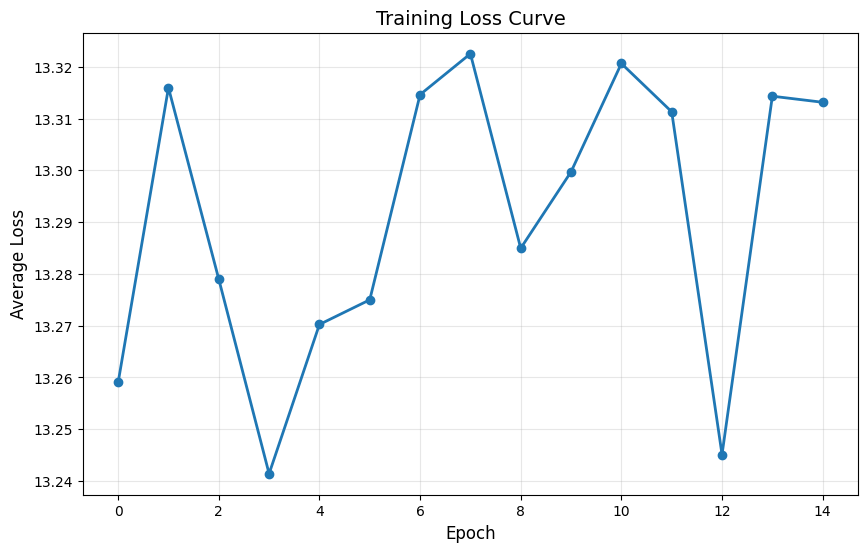

[13.25901917048863, 13.315942355564662, 13.278970854622978, 13.241402489798409, 13.270224162510463, 13.274984359741211, 13.314610345023018, 13.322509356907435, 13.28494153703962, 13.299704824175153, 13.320624215262276, 13.311295236860003, 13.245110375540596, 13.314307076590401, 13.313132558550153]


In [26]:
# Plot training loss curve


plt.figure(figsize=(10, 6))
plt.plot(loss_values, marker='o', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Average Loss', fontsize=12)
plt.title('Training Loss Curve', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

print(loss_values)

In [21]:
# Training score
true_labels = y_test_encoded
predicted_labels = []
net1.eval()
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = net1(images)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())

accuracy = np.mean([true == pred for true, pred in zip(true_labels, predicted_labels)])
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"1st network accuracy: {accuracy * 100:.2f}%")
print(f"1st network precision: {precision * 100:.2f}%")
print(f"1st network recall: {recall * 100:.2f}%")
print(f"1st network F1 score: {f1 * 100:.2f}%")

print(classification_report(true_labels, predicted_labels))

# Log test metrics
wandb.log({
    "test_accuracy": accuracy,
    "test_precision": precision,
    "test_recall": recall,
    "test_f1": f1
})

wandb.finish()

c:\conda-envs\envs\DLankle\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\conda-envs\envs\DLankle\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\conda-envs\envs\DLankle\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\conda-envs\envs\DLankle\Lib\site-packages\s

1st network accuracy: 32.65%
1st network precision: 67.08%
1st network recall: 32.65%
1st network F1 score: 40.22%
              precision    recall  f1-score   support

           0       0.11      0.43      0.17         7
           1       0.76      0.31      0.44        42
           2       0.00      0.00      0.00         0

    accuracy                           0.33        49
   macro avg       0.29      0.25      0.20        49
weighted avg       0.67      0.33      0.40        49



epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_loss,█▅▆▇▅▃▂▁▃▂▂▂▁▂▁
epoch,15
test_accuracy,0.32653
test_f1,0.40221
test_precision,0.67077
test_recall,0.32653


In [24]:
def init_weights(m):
    if isinstance(m, torch.nn.Conv2d):
        torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)
    elif isinstance(m, torch.nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)


torch.cuda.empty_cache()

net2 = torch.nn.Sequential(
    torch.nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),  # 224x224 -> 112x112
    torch.nn.ReLU(),
    torch.nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 112x112 -> 56x56
    torch.nn.ReLU(),
    torch.nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # 56x56 -> 28x28
    torch.nn.ReLU(),
    torch.nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # 28x28 -> 14x14
    torch.nn.ReLU(),
    torch.nn.Flatten(),
    torch.nn.Linear(256 * 14 * 14, 128),  # 256 channels * 14 * 14 spatial size
    torch.nn.ReLU(),
    torch.nn.Linear(128, 3)  # 3 classes output
).to(device)

net2.apply(init_weights)


loss_values = []

net2.train()
for epoch in tqdm(range(num_epochs), desc='Training model'):
    epoch_loss = 0.0
    num_batches = 0
    for images, target_labels in train_loader:
        images = images.to(device)
        target_labels = target_labels.to(device)

        pred_logits = net2(images)
        loss = loss_fn(pred_logits, target_labels)
        epoch_loss += loss.item()
        num_batches += 1

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    avg_epoch_loss = epoch_loss / num_batches
    loss_values.append(avg_epoch_loss)
    wandb.log({"epoch": epoch + 1, "train_loss": avg_epoch_loss})
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_epoch_loss:.4f}")

Training model:  13%|█▎        | 2/15 [00:00<00:03,  4.09it/s]

Epoch 1/15, Average Loss: 13.2590
Epoch 2/15, Average Loss: 13.3159


Training model:  27%|██▋       | 4/15 [00:00<00:01,  5.99it/s]

Epoch 3/15, Average Loss: 13.2790
Epoch 4/15, Average Loss: 13.2414


Training model:  40%|████      | 6/15 [00:01<00:01,  6.93it/s]

Epoch 5/15, Average Loss: 13.2702
Epoch 6/15, Average Loss: 13.2750


Training model:  53%|█████▎    | 8/15 [00:01<00:01,  6.64it/s]

Epoch 7/15, Average Loss: 13.3146
Epoch 8/15, Average Loss: 13.3225


Training model:  67%|██████▋   | 10/15 [00:01<00:00,  7.20it/s]

Epoch 9/15, Average Loss: 13.2849
Epoch 10/15, Average Loss: 13.2997


Training model:  80%|████████  | 12/15 [00:01<00:00,  7.51it/s]

Epoch 11/15, Average Loss: 13.3206
Epoch 12/15, Average Loss: 13.3113


Training model:  93%|█████████▎| 14/15 [00:02<00:00,  6.72it/s]

Epoch 13/15, Average Loss: 13.2451
Epoch 14/15, Average Loss: 13.3143


Training model: 100%|██████████| 15/15 [00:02<00:00,  6.44it/s]

Epoch 15/15, Average Loss: 13.3131


In [25]:
# Training score
true_labels = y_test_encoded
predicted_labels = []
net2.eval()
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = net2(images)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())

accuracy = np.mean([true == pred for true, pred in zip(true_labels, predicted_labels)])
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"1st network accuracy: {accuracy * 100:.2f}%")
print(f"1st network precision: {precision * 100:.2f}%")
print(f"1st network recall: {recall * 100:.2f}%")
print(f"1st network F1 score: {f1 * 100:.2f}%")

print(classification_report(true_labels, predicted_labels))

# Log test metrics
wandb.log({
    "test_accuracy": accuracy,
    "test_precision": precision,
    "test_recall": recall,
    "test_f1": f1
})

wandb.finish()

c:\conda-envs\envs\DLankle\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\conda-envs\envs\DLankle\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\conda-envs\envs\DLankle\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\conda-envs\envs\DLankle\Lib\site-packages\s

1st network accuracy: 55.10%
1st network precision: 70.13%
1st network recall: 55.10%
1st network F1 score: 61.71%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.82      0.64      0.72        42
           2       0.00      0.00      0.00         0

    accuracy                           0.55        49
   macro avg       0.27      0.21      0.24        49
weighted avg       0.70      0.55      0.62        49



epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_loss,▃▇▄▁▃▄▇█▅▆█▇▁▇▇
epoch,15
test_accuracy,0.55102
test_f1,0.61714
test_precision,0.7013
test_recall,0.55102
